# TP3

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 

### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

In [10]:
image_template = cv2.imread('TP3/template/pattern.png', cv2.IMREAD_GRAYSCALE)
# w, h = image_template.shape[::-1]

image_1 =  cv2.imread('TP3/images/COCA-COLA-LOGO.jpg', cv2.IMREAD_GRAYSCALE)
print(image_1.shape)
image_2 =  cv2.imread('TP3/images/coca_logo_1.png', cv2.IMREAD_GRAYSCALE)
print(image_2.shape)
image_3 =  cv2.imread('TP3/images/coca_logo_2.png', cv2.IMREAD_GRAYSCALE)
print(image_3.shape)
image_4 =  cv2.imread('TP3/images/coca_multi.png', cv2.IMREAD_GRAYSCALE)
print(image_4.shape)
image_5 =  cv2.imread('TP3/images/coca_retro_1.png', cv2.IMREAD_GRAYSCALE)
print(image_5.shape)
image_6 =  cv2.imread('TP3/images/coca_retro_2.png', cv2.IMREAD_GRAYSCALE)
print(image_6.shape)
image_7 =  cv2.imread('TP3/images/logo_1.png', cv2.IMREAD_GRAYSCALE)
print(image_7.shape)


(1389, 1389)
(500, 207)
(363, 233)
(598, 799)
(493, 715)
(429, 715)
(450, 687)


In [13]:
def binarize_image(image):
    _, binary_image = cv2.threshold(image_template, 200, 255, cv2.THRESH_BINARY)
    return binary_image

(175, 400)


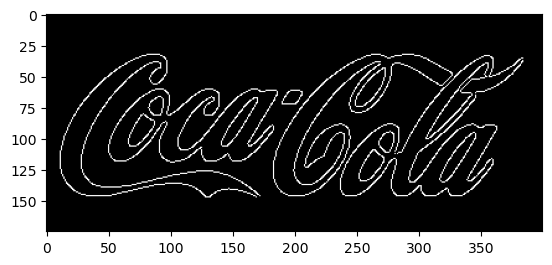

In [162]:
# Template preprocessing
image_template_binary = binarize_image(image_template)
print(image_template_binary.shape)

# plt.imshow(cv2.pyrUp(cv2.pyrUp(image_template_binary)), cmap='gray')
# print(image_template_binary.shape)
# image_template_binary = cv2.pyrUp(image_template_binary-255)
image_template_binary = image_template_binary
# plt.imshow(image_template_binary, cmap='gray')

edges = cv2.Canny(image_template_binary, 100, 200)
# edges = cv2.Laplacian(image_template_binary, cv2.CV_64F)

plt.imshow(edges, cmap='gray')
image_template_binary = edges


(429, 715)


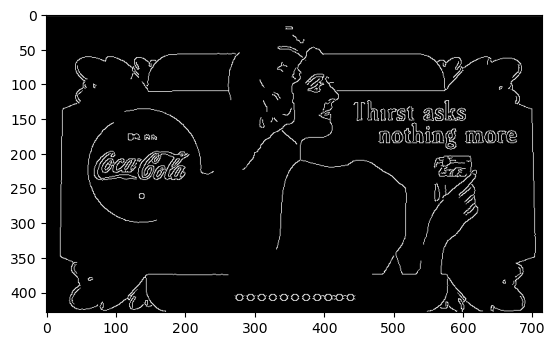

In [179]:
# Image preprocessing
# ret, image_1_binary = cv2.threshold(image_6, 200, 255, cv2.THRESH_BINARY)
image_1_binary=image_6
# image_1_binary = image_1_binary-255
plt.imshow(image_1_binary, cmap='gray')
print(image_1_binary.shape)
image_1_binary = cv2.GaussianBlur(image_1_binary,(5,5),0)
edges_1 = cv2.Canny(image_1_binary, 100, 200)

# edges_1 = cv2.Laplacian(image_1_binary, cv2.CV_64F)

plt.imshow(edges_1, cmap='gray')
image_1_binary = edges_1

(18, 40)
-0.125 1417799.75 (620, 144) (140, 215)
(19, 44)
-0.1328125 1456049.875 (30, 148) (139, 217)
(21, 48)
-0.21875 1869149.75 (115, 142) (81, 206)
(23, 52)
-0.125 2050964.875 (604, 128) (155, 214)
(24, 56)
-0.1875 2492114.75 (423, 152) (141, 211)
(26, 60)
-0.25 2177445.0 (416, 162) (70, 202)
(28, 64)
-0.3125 2829479.75 (411, 161) (98, 200)
(30, 68)
-0.25 2952389.5 (374, 215) (131, 211)
(31, 72)
-0.25 2927400.0 (384, 215) (90, 207)
(33, 76)
-0.375 3761760.0 (406, 215) (129, 211)
(35, 80)
-0.25 3987180.0 (179, 117) (121, 206)
(37, 84)
-0.25 4115444.5 (256, 210) (80, 197)
(38, 88)
-0.265625 4396709.5 (173, 71) (74, 196)
(40, 92)
-0.3125 4777934.0 (213, 122) (90, 196)
(42, 96)
-0.375 5722454.5 (241, 210) (69, 194)
(44, 100)
-0.25 5863214.0 (216, 111) (102, 197)
(45, 104)
-0.3125 6140654.0 (217, 107) (73, 193)
(47, 108)
-0.375 6742199.0 (346, 212) (67, 192)
(49, 112)
-0.375 6896730.0 (198, 117) (93, 194)
(51, 116)
-0.4375 7591094.5 (232, 199) (87, 192)
(52, 120)
-0.4375 7832068.5 (190,

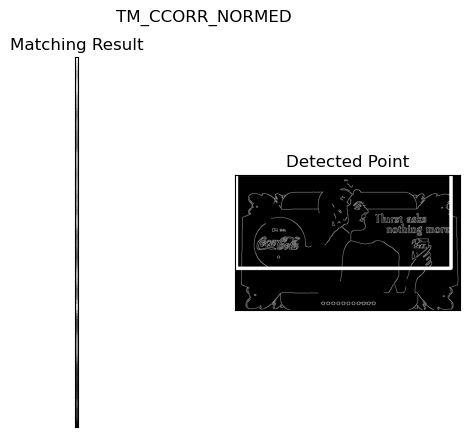

In [180]:
# All the 6 methods for comparison in a list
methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
            'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
 
# scales = np.linspace(1, 20, 10) # image_1
scales = np.linspace(0.1, 100, 10000) # image_3
max_value = 0
img_max = None
for scale in scales:
    image_template_binary_resize = cv2.resize(image_template_binary, None, fx=scale, fy=scale)
    print(image_template_binary_resize.shape)
    
    img = image_1_binary.copy()
    # method = getattr(cv2, meth)
 
    # Apply template Matching
    try:
        res = cv2.matchTemplate(img,image_template_binary_resize, cv2.TM_CCORR)
    except Exception as e:
        break
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(min_val, max_val, min_loc, max_loc)
 
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    # if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
    #     top_left = min_loc
    # else:
    top_left = max_loc
    w, h = image_template_binary_resize.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv2.rectangle(img,top_left, bottom_right, 255, 2)
    # 
    # plt.subplot(121),plt.imshow(res,cmap = 'gray')
    # plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(img,cmap = 'gray')
    # plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    # plt.suptitle('TM_CCORR_NORMED')
    # plt.show()
 
    if max_val > max_value:
        img_max = img.copy()
        top_left_max = max_loc
        w, h = image_template_binary_resize.shape[::-1]
        bottom_right_max = (top_left_max[0] + w, top_left_max[1] + h)
        max_value = max_val
 
cv2.rectangle(img_max,top_left_max, bottom_right_max, 255, 10)
 
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_max,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED')
plt.show()

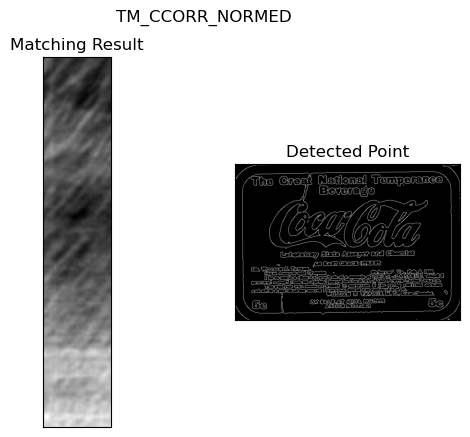

In [123]:
cv2.rectangle(img_max,top_left_max, bottom_right_max, 255, 2)
 
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED')
plt.show()

In [7]:
] # Crear el detector ORB
orb = cv2.ORB_create()

# Detectar y computar características clave y descriptores
keypoints_logo, descriptors_logo = orb.detectAndCompute(template_image, None)
keypoints_image, descriptors_image = orb.detectAndCompute(image_2, None)

In [8]:
# Usar el matcher BruteForce-Hamming (adecuado para ORB)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Encontrar las coincidencias
matches = bf.match(descriptors_logo, descriptors_image)

# Ordenar las coincidencias por distancia
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar las mejores coincidencias
result = cv2.drawMatches(template_image, keypoints_logo, image_2, keypoints_image, matches[:20], None, flags=2)

# Mostrar el resultado
cv2.imshow("Coincidencias", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
# Extraer los puntos clave correspondientes
src_pts = np.float32([keypoints_logo[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_image[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Calcular la homografía
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Obtener las dimensiones del logo
h, w = template_image.shape

# Definir las esquinas del logo
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

# Transformar las esquinas según la homografía
dst = cv2.perspectiveTransform(pts, M)

# Dibujar las esquinas del logo detectado en la imagen
image = cv2.polylines(image_2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

# Mostrar el resultado final
cv2.imshow("Logo detectado", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:

# Convertir a escala de grises (opcional, pero suele mejorar el rendimiento)
gray_image = image_5.copy()
gray_template = template_image.copy()

# Obtener dimensiones del template
template_height, template_width = gray_template.shape[:2]

# Variables para guardar los mejores resultados
best_match = None
best_value = -1  # Inicializar con un valor bajo para comparar
best_scale = 1
best_position = (0, 0)

# Probar diferentes escalas de la imagen
for scale in np.linspace(0.5, 1.5, 20):  # Escalar de 50% a 150%
    resized_template = cv2.resize(gray_template, (int(template_width * scale), int(template_height * scale)))

    # Evitar que el template sea más grande que la imagen
    if resized_template.shape[0] > gray_image.shape[0] or resized_template.shape[1] > gray_image.shape[1]:
        continue

    # Aplicar el template matching
    result = cv2.matchTemplate(gray_image, resized_template, cv2.TM_CCOEFF_NORMED)

    # Obtener el valor máximo de coincidencia y su ubicación
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Guardar la mejor coincidencia
    if max_val > best_value:
        best_value = max_val
        best_match = resized_template
        best_position = max_loc
        best_scale = scale

# Dibujar un rectángulo alrededor del logo detectado
top_left = best_position
bottom_right = (top_left[0] + int(template_width * best_scale), top_left[1] + int(template_height * best_scale))
cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

# Mostrar el resultado
cv2.imshow('Logo detectado', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
image_1_down = cv2.pyrDown(image_1)
image_1_2down = cv2.pyrDown(image_1_down)
image_1_up = cv2.pyrUp(image_1)
image_1_2up = cv2.pyrUp(image_1_up)
cv2.imshow('Logo detectado', image_1_up)
cv2.waitKey(0)
cv2.destroyAllWindows()